# Analysis of the di-muon spectrum using data from the CMS detector

This analysis extracts the mass spectrum of di-muons produced in proton-proton collisions at sqrt(s)=7TeV data from the CMS experiment data recorded in 2012 during Run B and C. It is implemented using the [Julia](https://julialang.org/) language and can run in a Jupyter notebook. Python and C++ version of this analysis can be found [here](https://opendata.web.cern.ch/record/12342).

The spectrum is computed from the data by calculating the invariant mass of muon pairs with opposite charge. In the resulting plot, you are able to rediscover particle resonances in a wide energy range from the [eta meson](https://en.wikipedia.org/wiki/Eta_meson) at about 548 MeV up to the [Z boson](https://en.wikipedia.org/wiki/W_and_Z_bosons) at about 91 GeV.

The analysis code produces a plot with the dimuon spectrum. Note that the bump at 30 GeV is not a resonance but an effect of the data taking due to the used trigger. The technical description of the dataset can be found in the respective record linked below.

The result of this analysis can be compared with [an official result of the CMS collaboration using data taken in 2010](https://cds.cern.ch/record/1456510), see the plot below:

![](http://cds.cern.ch/record/1456510/files/pictures_samples_dimuonSpectrum_40pb-1_mod-combined.png)

# Dataset description

The dataset consists of the following columns.

| Column name | Data type | Description |
|-------------|-----------|-------------|
| `nMuon` | `unsigned int` | Number of muons in this event |
| `Muon_pt` | `float[nMuon]` | Transverse momentum of the muons (stored as an array of size `nMuon`) |
| `Muon_eta` | `float[nMuon]` | Pseudorapidity of the muons |
| `Muon_phi` | `float[nMuon]` | Azimuth of the muons |
| `Muon_mass` | `float[nMuon]` | Mass of the muons |
| `Muon_charge` | `int[nMuon]` | Charge of the muons (either 1 or -1) |

## Software prerequeries

This notebook needs a [Julia kernel](https://julialang.github.io/IJulia.jl/stable/) to be executed in Jupyter. Start Jupyter with the `start_notebook.jl` script to get all dependencies automatically installed.

**Note**: We use Julia package manager to handle software dependencies and control software reproducibility. The used Julia packages are listed in the `Project.toml` file: `IJulia` is used as Jupyter kernel; `NBInclude` is used to include an auxiliary notebook; `UnROOT` is used to read the input data file; `Plots` and `GR` are used for plotting. 


Import the packages used in this notebook:

In [2]:
using NBInclude
using UnROOT
using Plots

## Some utilities we will need

Define four-momentum and histogram tools

In [3]:
@nbinclude("JuliaUtils.ipynb")

## The data file

To run this example, we need to download the CMS data file from [here](https://opendata.cern.ch/record/12341/files/Run2012BC_DoubleMuParked_Muons.root). If you don't have the command `wget` on your system you can download the file using your preferred web browser and save it with the name `Run2012BC_DoubleMuParked_Muons.root` in the directory containing this notebook.

The file to download is 1.2 GByte big.

In [4]:
run(`wget -c --progress dot:giga -O Run2012BC_DoubleMuParked_Muons.root "https://opendata.cern.ch/record/12341/files/Run2012BC_DoubleMuParked_Muons.root"`);

--2021-12-13 17:10:12--  https://opendata.cern.ch/record/12341/files/Run2012BC_DoubleMuParked_Muons.root
Resolving opendata.cern.ch (opendata.cern.ch)... 188.184.93.89, 188.185.82.144, 188.184.28.138, ...
Connecting to opendata.cern.ch (opendata.cern.ch)|188.184.93.89|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [5]:
fname = "Run2012BC_DoubleMuParked_Muons.root"

"Run2012BC_DoubleMuParked_Muons.root"

## The analysis

The function that will analyse the events. We select events with exactly two muons with opposite charges, compute the mass of the "dimuon" object formed by the two objects, and fill an histogram that will represent the dimuon mass spectrum.

In [6]:
function analyze_tree(t, maxevents = -1)
    bins = 30_000 # Number of bins in the histogram
    low = 0.25 # Lower edge of the histogram
    up = 300.0 # Upper edge of the histogram
    h = H1{Float64}(Axis(bins, low, up))
    for (ievt, evt) in enumerate(t)
        maxevents >= 0 && ievt > maxevents && break
        evt.nMuon ==2 || continue
        evt.Muon_charge[1] != evt.Muon_charge[2] || continue
        dimuon_mass = m(ptetaphim(evt.Muon_pt[1], evt.Muon_eta[1], evt.Muon_phi[1], evt.Muon_mass[1])
                        + ptetaphim(evt.Muon_pt[2], evt.Muon_eta[2], evt.Muon_phi[2], evt.Muon_mass[2]))
        hfill!(h, dimuon_mass)
    end
    h
end;

We will now run the function on the data stored in the input `fname` `ROOT` file. It will take about 40 seconds to run on the 61.5 million of events contained in the file.

In [7]:
t = LazyTree(ROOTFile(fname),"Events")
@time h = analyze_tree(t);

 29.644892 seconds (164.60 M allocations: 16.005 GiB, 9.39% gc time, 4.00% compilation time)


# Let's plot the result

For plotting we will use Plot.jl with the GR backend, that has a good support for annotations. See the [Plot.jl documentation](https://docs.juliaplots.org/latest/) for the list of backend options. PlotJS or PyPlot can be used for interactive plots.

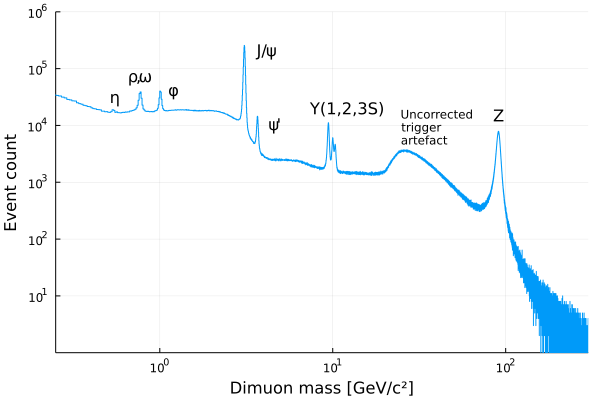

In [89]:
#Select the GR plotting backend:
gr()

#Make the plot:
plot(xedges(h), max.(0.25, vcat(h.sumw[2:end-1], [h.sumw[end-1]])),  
    seriestype=:steppre, leg=false, annotationfontsize=11,
    xaxis=("Dimuon mass [GeV/c²]", (0.25,300), :log),
    yaxis=("Event count", (1, 1.e6), 10 .^ (1:6), :log)
)

#Annotate the plot with the resonnance names:
annotate!([(0.55, 3.0e4, "\\eta",),
        (0.77, 7.0e4, "\\rho,\\omega"),
        (1.20, 4.0e4, "\\phi"),
        (4.10, 2.0e5, "J\\/\\psi"),
        (4.60, 1.0e4, "\\psi'"),
        (12.0, 2.0e4, "Y(1,2,3S)"),
        (25., 1.e4, ("Uncorrected\ntrigger\nartefact",8,:left)),
        (91.0, 1.5e4, "Z")])
